# ECE 311 Lab 3: Z-Transform and LSI Systems
## Due Date: 10/3 @ 11:59pm on Canvas

In this lab, we will explore how to work with the z-transform and apply some of the more abstract things you have learned in ECE 310 thus far. This will be a shorter lab since there will not be many applications. Let's get started with some background and review of the z-transform.

## Z-Transform Background

The z-transform is a linear transform that can be thought of as the discrete-time version of the Laplace transform from ECE 210. The z-transform is defined by:

$$
X(z) = \sum_{n=-\infty}^{\infty}x[n]z^{-n}.
$$

The z-transform can be visualized on the complex-valued z-plane where the x-axis is the real part of $z$ and the y-axis is the imaginary part of $z$. Therefore, like $s$ for the Laplace transform, $z$ has a real part and imaginary part. Furthermore, it is critical that we note the Region of Convergence (ROC) for each z-transform to guarantee its uniqueness. The ROC is defined as all values of $z$ that ensure the z-transform sum converges.

We frequently work with systems whose z-transform is given by a rational expression of the form

$$
X(z) = \frac{B(z)}{A(z)},
$$

where $A(z)$ and $B(z)$ are polynomials in $z^{-1}$. If we factorize the numerator and denominator, we arrive at a useful point of reference.

$$
X(z) = \frac{\prod_{i=1}^{N_z}(1-q_iz^{-1})}{\prod_{j=1}^{N_p}(1-p_jz^{-1})}
$$

In the above equation, each $q_i$ is a "zero" of the system and each $p_j$ is a "pole" of the system. When an input excites a pole of the system, the output blows up to infinty and when an input touches a zero, the output goes to zero. Note that both our poles and zeros can be complex valued! We depict our poles and zeros on a "pole-zero plot" of the z-plane where each pole is marked by an "x" and each zero is marked by an "o". The poles of an LSI system are essential to assessing BIBO stability. For a causal LSI system, the ROC is given by $|z| > p_{\textrm{max}}$, where $p_{\textrm{max}}$ is the largest or outermost pole. Conversely, for a non-causal LSI system, the ROC is given by $|z| < p_{\textrm{min}}$, the innermost or smallest pole. In either case, an LSI system is BIBO stable if and only if its ROC contains the unit circle: $|z| = 1$. Should the pole of interest lie on the unit circle, the system is marginally stable. But for this course and ECE 310, we say the system is unstable since there exists at least one bounded input that can create an unbounded output.

**For this lab, you may assume all systems are causal.**

The last thing we should discuss is how Linear Constant Coefficient Difference Equations (LCCDE) relate to the z-transform. Moving from an LCCDE is rather simple: we take the z-transform of both sides and remember to attach $z^-k$ for each term based on its delay argument according to the delay property of the z-transform. Below is an example of this process:

$$
y[n] - 3y[n-1] + 2y[n-2] = 2x[n] + x[n-1]
$$

Taking the z-transform of both sides:

$$
Y(z) - 3z^{-1}Y(z) + 2z^{-2}Y(z) = 2X(z) + z^{-1}X(z)
$$

$$
Y(z)(1-3z^{-1}+2z^{-2}) = X(z)(2+z^{-1})
$$

$$
H(z) = \frac{Y(z)}{X(z)} = \frac{2+z^{-1}}{1-3z^{-1}+2z^{-2}}\cdot\frac{z^2}{z^2} = \frac{2z^2 +z}{z^2-3z+2}
$$

Factorizing the above rational expression would show us that we have poles at $z = 1$ and $2$ and a zero at $z = -\frac{1}{2}$. Furthermore, this system must *not* be BIBO stable since it is causal and its largest pole lies outside the unit circle. 

**Note that while the two expressions shown in the last line are equivalent, the second one with positive exponents is more compatible with Python libaries as the scipy functions assume "controls" notation as opposed to our signal processing notation. For this lab, we will follow the notation that matches the scipy documentation.** We refer to the $H(z)$ shown above as the transfer function of the system. By convention a transfer function is defined as

$$
H(z) = \frac{\sum_{i=0}^{N-1}b_iz^{-i}}{1+\sum_{j=1}^{M-1}a_jz^{-j}}
$$

Note that the first term in the denominator is a "1" to represent the system output not being scaled. It is important to keep these conventions in mind when utilizing Python library functions that expect them. Now that the background is done, let's try out some code.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio # listening to audio

from pz_plot import pz_plot # pole-zero plotting utility
from scipy import signal
from scipy.io import wavfile # audio i/o

%matplotlib inline

We will start by working from a transfer function to its pole-zero plot and corresponding impulse response. Our example system is given by:

$$
H(z) = \frac{z^{2}-\frac{1}{2}z}{z^2-z+1}
$$

To extract its poles and zeros we will use $\textrm{signal.tf2zpk()}$. We have provided a plotting function that takes a list or array of poles and zeros, respectively, to visualize the resulting pole-zero plot.

Poles: [0.5+0.8660254j 0.5-0.8660254j]
Zeros: [0.5 0. ]


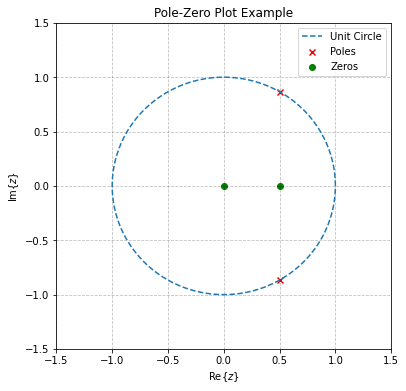

In [2]:
b = [1, -0.5, 0] # numerator coefficients, make sure to align zeros where delay terms don't align
a = [1, -1, 1] # denominator coefficients
z, p, k = signal.tf2zpk(b, a) # k is system gain -> okay to ignore this

print('Poles:', p)
print('Zeros:', z)
"""
pz_plot(zeros_list, poles_list, plot_title)
zeros_list = list or array of transfer function's zeros
poles_list = list or array of transfer function's poles
plot_title = string for title of your plot
"""

pz_plot(z, p, 'Pole-Zero Plot Example')

Next, we can find the impulse response of our system using $\textrm{signal.dimpulse()}$. There are a few ways to use this function and we will opt to use the system coefficients ($a$ and $b$).

<ipython-input-3-78608dd2a1dd>:5: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  plt.stem(n, h_n) # plot first 20 samples of impulse response


Text(0.5, 1.0, 'Impulse Response of Example System')

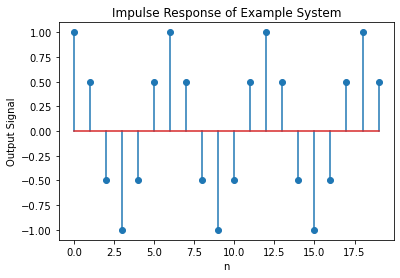

In [3]:
n,y = signal.dimpulse((b, a, 1), n=20) # the 1 is for the change in time per sample, n=20 means 20 points for output
h_n = y[0] # need to access output from returned object

plt.figure()
plt.stem(n, h_n) # plot first 20 samples of impulse response
plt.xlabel('n')
plt.ylabel('Output Signal')
plt.title('Impulse Response of Example System')

# Exercise 1: Working with Transfer Functions

For each of the following transfer functions, plot the pole-zero plot and (stem plot) impulse response for the requested number of points using the previously discussed functions. Try to verify the poles and zeros you find and the resulting impulse response by hand. Explain why each system is BIBO stable or not. If the system is not BIBO stable, give an example of a bounded input that would yield an unbounded output.

$
\begin{align}
a. H_1(z) = \frac{1}{2} + \frac{1}{4}z^{-2} - \frac{1}{4}z^{-4}, \quad 0\leq n\leq 5
\end{align}
$

$
\begin{align}
b. H_2(z) = \frac{\frac{1}{2}z^2+\frac{1}{4}z}{z^2-\frac{\sqrt{2}}{2}z+\frac{1}{4}}, \quad 0\leq n\leq 20
\end{align}
$

$
\begin{align}
c. H_3(z) = \frac{z^3+z^2}{z^3-1}, \quad 0\leq n\leq 20
\end{align}
$

Poles: [0. 0. 0. 0.]
Zeros: [ 1.21430643e-16+1.j  1.21430643e-16-1.j -7.07106781e-01+0.j
  7.07106781e-01+0.j]
Poles: [0.35355339+0.35355339j 0.35355339-0.35355339j]
Zeros: [-0.5  0. ]
Poles: [-0.5+0.8660254j -0.5-0.8660254j  1. +0.j       ]
Zeros: [-1.  0.  0.]


<ipython-input-13-298934941c4a>:14: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  plt.stem(n, h_n) # plot first 6 samples of impulse response
<ipython-input-13-298934941c4a>:31: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  plt.stem(n, h_n) # plot first 6 samples of impulse response
<ipython-input-13-298934941c4a>:49: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of

Text(0.5, 1.0, 'Impulse Response of Example System')

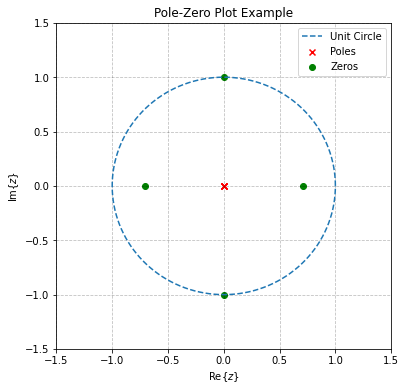

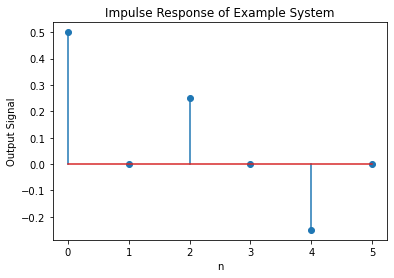

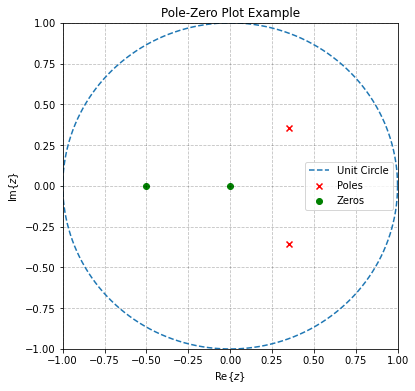

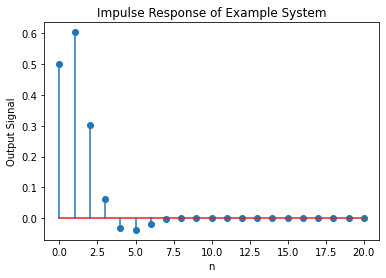

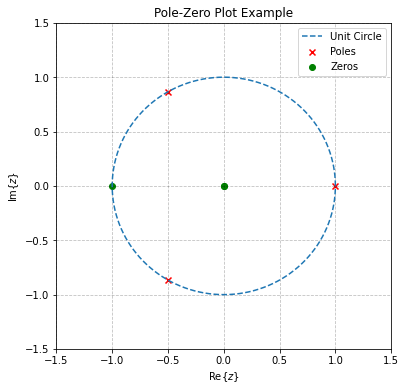

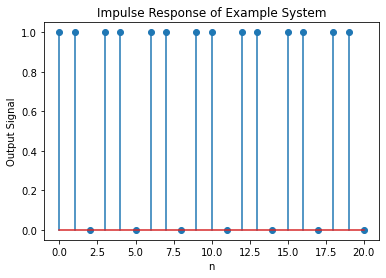

In [13]:
# Code for 1.a
b = [2, 0, 1, 0, -1] # numerator coefficients, make sure to align zeros where delay terms don't align
a = [4, 0, 0, 0, 0] # denominator coefficients
z, p, k = signal.tf2zpk(b, a) # k is system gain -> okay to ignore this

print('Poles:', p)
print('Zeros:', z)
pz_plot(z, p, 'Pole-Zero Plot Example')

n,y = signal.dimpulse((b, a, 1), n=6) # the 1 is for the change in time per sample, n=20 means 20 points for output
h_n = y[0] # need to access output from returned object

plt.figure()
plt.stem(n, h_n) # plot first 6 samples of impulse response
plt.xlabel('n')
plt.ylabel('Output Signal')
plt.title('Impulse Response of Example System')
# Code for 1.b
b = [1/2, 1/4, 0] # numerator coefficients, make sure to align zeros where delay terms don't align
a = [1, -np.sqrt(2)/2, 1/4] # denominator coefficients
z, p, k = signal.tf2zpk(b, a) # k is system gain -> okay to ignore this

print('Poles:', p)
print('Zeros:', z)
pz_plot(z, p, 'Pole-Zero Plot Example')

n,y = signal.dimpulse((b, a, 1), n=21) # the 1 is for the change in time per sample, n=20 means 20 points for output
h_n = y[0] # need to access output from returned object

plt.figure()
plt.stem(n, h_n) # plot first 21 samples of impulse response
plt.xlabel('n')
plt.ylabel('Output Signal')
plt.title('Impulse Response of Example System')

# Code for 1.c
b = [1, 1, 0, 0] # numerator coefficients, make sure to align zeros where delay terms don't align
a = [1, 0, 0, -1] # denominator coefficients
z, p, k = signal.tf2zpk(b, a) # k is system gain -> okay to ignore this

print('Poles:', p)
print('Zeros:', z)
pz_plot(z, p, 'Pole-Zero Plot Example')

n,y = signal.dimpulse((b, a, 1), n=21) # the 1 is for the change in time per sample, n=20 means 20 points for output
h_n = y[0] # need to access output from returned object

plt.figure()
plt.stem(n, h_n) # plot first 21 samples of impulse response
plt.xlabel('n')
plt.ylabel('Output Signal')
plt.title('Impulse Response of Example System')


## Comments here:

Part 1(a): Not BIBO, as there are two zeros on the unit circle.


Part 1(b): BIBO, Because all the poles and zeros are within the unit circle.


Part 1(c): Not BIBO, as there are poles and zeros on the unit circle.


# Exercise 2: Working from an LCCDE

For each of the following LCCDEs, determine the numerator and denominator coefficients, $a$ and $b$, respectively by hand. Using these coefficients, plot the pole-zero plot and impulse response for the requested number of points. Explain why each system is BIBO stable or not.

$\begin{align}
a. y_1[n] = x[n] - \frac{1}{2}x[n-1] + \frac{1}{4}x[n-2] - \frac{1}{8}x[n-3], \quad 0 \leq n \leq 5
\end{align}$

$\begin{align}
b.y_2[n] = y[n-1] - 2y[n-2] + y[n-3] + x[n] + \frac{1}{2}x[n-1], \quad 0\leq n \leq 20
\end{align}$

$\begin{align}
c. y_3[n] = \frac{1}{2}y[n-1] + \frac{1}{4}y[n-2] + \frac{1}{2}x[n] + \frac{1}{4}x[n-1], \quad 0\leq n \leq 20
\end{align}$

d. Is it possible for a system with a finite-length impulse response (FIR) like the one in 2.a to not be BIBO stable? Why or why not?

Poles: [0. 0. 0.]
Zeros: [5.00000000e-01+0.j  1.94289029e-16+0.5j 1.94289029e-16-0.5j]
Poles: [0.21507985+1.30714128j 0.21507985-1.30714128j 0.56984029+0.j        ]
Zeros: [-0.5  0.   0. ]
Poles: [ 0.80901699 -0.30901699]
Zeros: [-0.5  0. ]


<ipython-input-89-21dd81278e17>:14: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  plt.stem(n, h_n) # plot first 6 samples of impulse response
<ipython-input-89-21dd81278e17>:32: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  plt.stem(n, h_n) # plot first 21 samples of impulse response
<ipython-input-89-21dd81278e17>:51: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance o

Text(0.5, 1.0, 'Impulse Response of Example System')

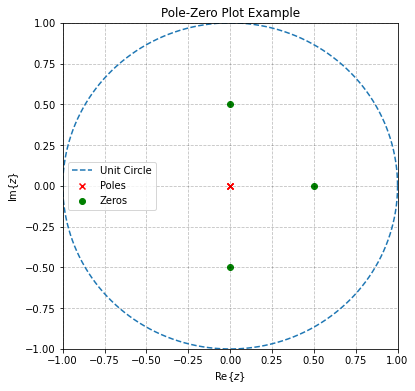

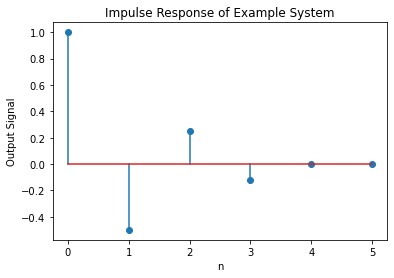

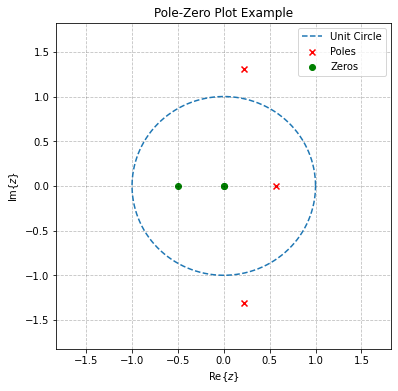

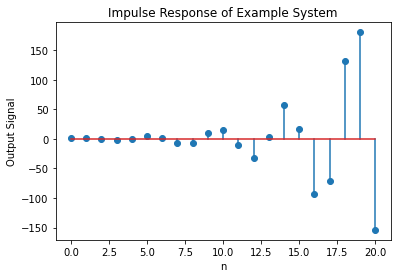

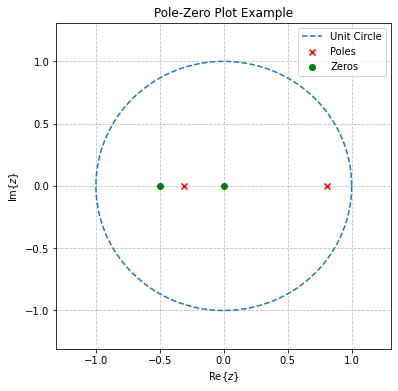

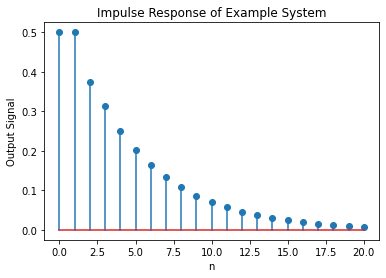

In [89]:
# Code for 2.a
b = [1, -1/2, 1/4, -1/8]
a = [1, 0, 0, 0]
z, p, k = signal.tf2zpk(b, a) # k is system gain -> okay to ignore this

print('Poles:', p)
print('Zeros:', z)
pz_plot(z, p, 'Pole-Zero Plot Example')

n,y = signal.dimpulse((b, a, 1), n=6) # the 1 is for the change in time per sample, n=20 means 20 points for output
h_n = y[0] # need to access output from returned object

plt.figure()
plt.stem(n, h_n) # plot first 6 samples of impulse response
plt.xlabel('n')
plt.ylabel('Output Signal')
plt.title('Impulse Response of Example System')

# Code for 2.b
b = [1, 1/2, 0, 0]
a = [1, -1, 2, -1]
z, p, k = signal.tf2zpk(b, a) # k is system gain -> okay to ignore this

print('Poles:', p)
print('Zeros:', z)
pz_plot(z, p, 'Pole-Zero Plot Example')

n,y = signal.dimpulse((b, a, 1), n=21) # the 1 is for the change in time per sample, n=20 means 20 points for output
h_n = y[0] # need to access output from returned object

plt.figure()
plt.stem(n, h_n) # plot first 21 samples of impulse response
plt.xlabel('n')
plt.ylabel('Output Signal')
plt.title('Impulse Response of Example System')


# Code for 2.c
b = [1/2, 1/4, 0]
a = [1, -1/2, -1/4]
z, p, k = signal.tf2zpk(b, a) # k is system gain -> okay to ignore this

print('Poles:', p)
print('Zeros:', z)
pz_plot(z, p, 'Pole-Zero Plot Example')

n,y = signal.dimpulse((b, a, 1), n=21) # the 1 is for the change in time per sample, n=20 means 20 points for output
h_n = y[0] # need to access output from returned object

plt.figure()
plt.stem(n, h_n) # plot first 21 samples of impulse response
plt.xlabel('n')
plt.ylabel('Output Signal')
plt.title('Impulse Response of Example System')



## Comments here:

Part 2(a): BIBO stable as all poles and zeros are within the unit circle.


Part 2(b): Not BIBO stable as there is pole outside the unit circle.


Part 2(c): BIBO stable as all poles and zeros are within the unit circle.


Part 2(d): There is no possibility that poles will always 0 and cannot be outside the unit circle.
    
    

# Exercise 3: Applying a Filter using Transfer Functions

So far, we have only characterized LSI systems. Now let's use them as filters! Using $\textrm{signal.lfilter(b, a, input)}$ apply each of the following filters to each of the inputs. Plot the resulting outputs for the same length as the provided input signals. You may find documentation for the filtering function <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lfilter.html">here</a>.

$\begin{align}
a. H_1(z) = \frac{1}{2} - \frac{1}{2}z^{-1} + \frac{1}{2}z^{-2}
\end{align}$

$\begin{align}
b. y_2[n] = \frac{1}{2}y[n-1] + x[n] - x[n-2]
\end{align}$

$
\begin{align}
    \bullet~x_1[n] = \cos\left(\frac{\pi}{2}n\right), \quad 0 \leq n \leq 10
\end{align}
$

$
\begin{align}
    \bullet~x_2[n] = \left(\frac{1}{3}\right)^nu[n], \quad 0 \leq n \leq 10
\end{align}
$


<ipython-input-90-12362fca9ece>:8: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  plt.stem(n, h_n) # plot first 21 samples of impulse response
<ipython-input-90-12362fca9ece>:19: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  plt.stem(n, h_n) # plot first 21 samples of impulse response


Text(0.5, 1.0, 'x_1 Response of Example System')

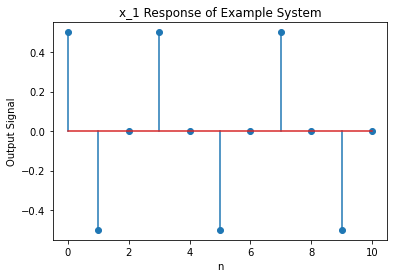

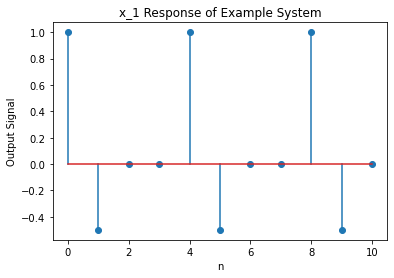

In [90]:
# Code for System A:
b = [1/2, -1/2, 1/2]
a = [1, 0, 0]
x_1 = np.array([np.cos(np.pi/2*i) for i in range(11)])
h_n = signal.lfilter(b, a, x_1) # the 1 is for the change in time per sample, n=20 means 20 points for output
n = np.array([i for i in range(11)])
plt.figure()
plt.stem(n, h_n) # plot first 21 samples of impulse response
plt.xlabel('n')
plt.ylabel('Output Signal')
plt.title('x_1 Response of Example System')
# Code for System B:
b = [1, -1/2, 0]
a = [1, 0, -1]
x_1 = np.array([np.cos(np.pi/2*i) for i in range(11)])
h_n = signal.lfilter(b, a, x_1) # the 1 is for the change in time per sample, n=20 means 20 points for output
n = np.array([i for i in range(11)])
plt.figure()
plt.stem(n, h_n) # plot first 21 samples of impulse response
plt.xlabel('n')
plt.ylabel('Output Signal')
plt.title('x_1 Response of Example System')


# Exercise 4: Marginal Stability

For this exercise, we will explore that "gray area" of stability from ECE 310: marginal stability. Recall that an LTI system is referred to as marginally stable if its ROC is $|z| > 1$ or $|z| < 1$. The following two LTI systems are marginally stable:

$\begin{align}
H_1(z) = \frac{z^2}{z^2 + 1},
\end{align}$

$\begin{align}
H_2(z) = \frac{z^2}{z^2 - \sqrt{2}z + 1}.
\end{align}$

a. Plot the pole-zero plot for both systems ($H_1(z)$ and $H_2(z)$).

Now, let's examine each system's response to some bounded inputs.

b. Plot the filtering output for each system for each of the following inputs. Remember to use $\textrm{signal.lfilter()}$ to obtain the system results. Please plot each system's set of outputs in one figure using $\textrm{plt.subplot()}$ and label your figures uniquely.

$
\begin{align}
    \bullet~x_1[n] = u[n], \quad 0 \leq n \leq 200
\end{align}
$

$
\begin{align}
    \bullet~x_2[n] = \cos\left({\frac{\pi}{2}n}\right), \quad 0 \leq n \leq 200
\end{align}
$

$
\begin{align}
    \bullet~x_3[n] = \cos\left({\frac{\pi}{4}n}\right), \quad 0 \leq n \leq 200
\end{align}
$

c. Comment on the results. Specifically, which inputs cause unbounded outputs for each system and why?

Poles: [-0.+1.j  0.-1.j]
Zeros: [0. 0.]
Poles: [0.70710678+0.70710678j 0.70710678-0.70710678j]
Zeros: [0. 0.]


Text(0.5, 1.0, 'x_3 H_2 Response of Example System')

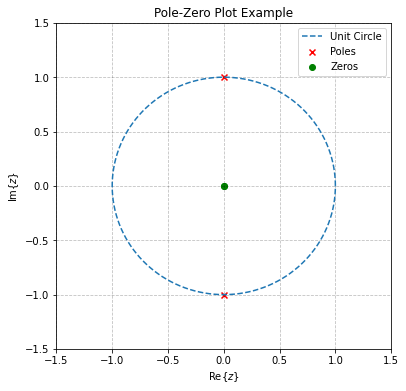

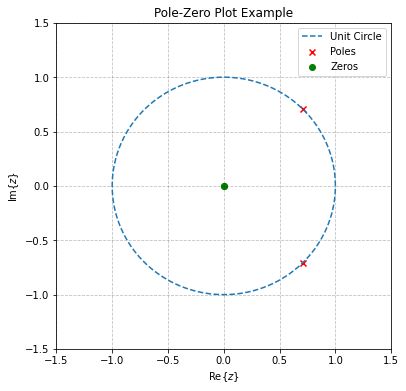

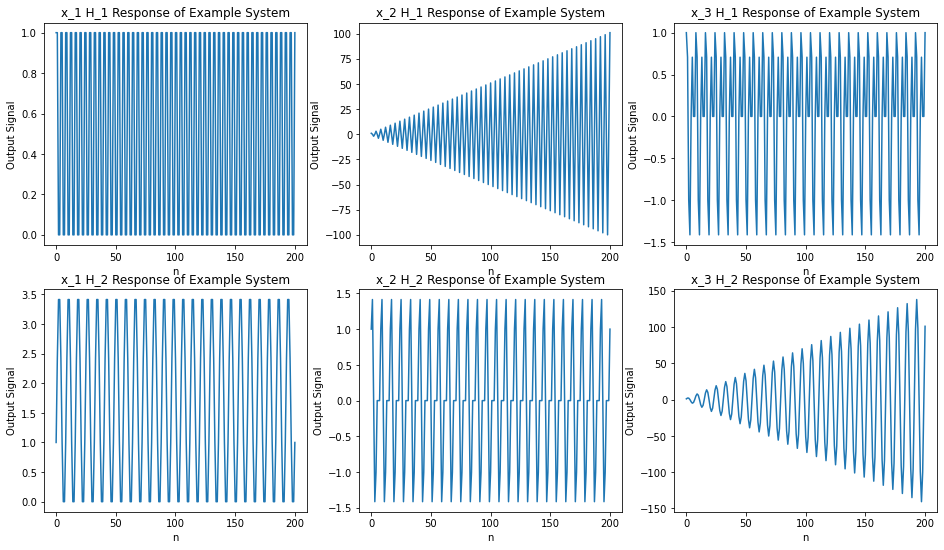

In [88]:
# Code for 4.a:
a = [1, 0, 0]
b = [1, 0, 1]
z, p, k = signal.tf2zpk(a, b) # k is system gain -> okay to ignore this
print('Poles:', p)
print('Zeros:', z)
pz_plot(z, p, 'Pole-Zero Plot Example')
a = [1, 0, 0]
b = [1, -np.sqrt(2), 1]
z, p, k = signal.tf2zpk(a, b) # k is system gain -> okay to ignore this
print('Poles:', p)
print('Zeros:', z)
pz_plot(z, p, 'Pole-Zero Plot Example')
# Code for 4.b:
a = [1, 0, 0]
b = [1, 0, 1]
x_1 = np.ones(201)
h_n = signal.lfilter(a, b, x_1) # the 1 is for the change in time per sample, n=20 means 20 points for output
n = np.array([i for i in range(201)])
plt.figure(figsize = (16,9))
figure = plt.subplot(231) # plot first 21 samples of impulse response
figure.plot(n,h_n)
plt.xlabel('n')
plt.ylabel('Output Signal')
plt.title('x_1 H_1 Response of Example System')

x_1 = np.array([np.cos(np.pi/2*i) for i in range(201)])
h_n = signal.lfilter(a, b, x_1) # the 1 is for the change in time per sample, n=20 means 20 points for output
n = np.array([i for i in range(201)])
figure = plt.subplot(232) # plot first 21 samples of impulse response
figure.plot(n,h_n)
plt.xlabel('n')
plt.ylabel('Output Signal')
plt.title('x_2 H_1 Response of Example System')

x_1 = np.array([np.cos(np.pi/4*i) for i in range(201)])
h_n = signal.lfilter(a, b, x_1) # the 1 is for the change in time per sample, n=20 means 20 points for output
n = np.array([i for i in range(201)])
figure3 = plt.subplot(233) # plot first 21 samples of impulse response
figure3.plot(n,h_n)
plt.xlabel('n')
plt.ylabel('Output Signal')
plt.title('x_3 H_1 Response of Example System')

a = [1, 0, 0]
b = [1, -np.sqrt(2), 1]
x_1 = np.ones(201)
h_n = signal.lfilter(a, b, x_1) # the 1 is for the change in time per sample, n=20 means 20 points for output
n = np.array([i for i in range(201)])
figure = plt.subplot(234) # plot first 21 samples of impulse response
figure.plot(n,h_n)
plt.xlabel('n')
plt.ylabel('Output Signal')
plt.title('x_1 H_2 Response of Example System')

x_1 = np.array([np.cos(np.pi/2*i) for i in range(201)])
h_n = signal.lfilter(a, b, x_1) # the 1 is for the change in time per sample, n=20 means 20 points for output
n = np.array([i for i in range(201)])
figure = plt.subplot(235) # plot first 21 samples of impulse response
figure.plot(n,h_n)
plt.xlabel('n')
plt.ylabel('Output Signal')
plt.title('x_2 H_2 Response of Example System')

x_1 = np.array([np.cos(np.pi/4*i) for i in range(201)])
h_n = signal.lfilter(a, b, x_1) # the 1 is for the change in time per sample, n=20 means 20 points for output
n = np.array([i for i in range(201)])
figure3 = plt.subplot(236) # plot first 21 samples of impulse response
figure3.plot(n,h_n)
plt.xlabel('n')
plt.ylabel('Output Signal')
plt.title('x_3 H_2 Response of Example System')
# Remember to use subplots!


## Comments here:

Part 4(c): For system H_1 I consider that x_2 output is unbounded. For H_2 is x_3 output. Because they just meet the frequency of the pole of the system and made the output signal larger and larger.


# Exercise 5: Inverse Filtering

Suppose we are transmitting audio through a low-quality channel modeled by the following system

$$
y[n] = -y[n-1] - \frac{1}{4}y[n-2] + 2x[n] - 2x[n-2],
$$

where $x$ is our input and $y$ is the channel output. The provided audio clip ``distorted-audio.wav`` is an example of audio corrupted by this channel. If we would like to correct this signal, we need to undo the effects of the channel. Note that the received signal $y[n]$ has a z-transform of

$$
Y(z) = H(z)X(z),
$$

where $H(z)$ is the transfer function of the channel. How can we fix our audio? Apply a filter that is the inverse of the problematic channel! So, what are you waiting for? Go save the day!

a. Determine the transfer function of the required inverse filter and apply it to the ``distorted-audio.wav`` file data. Play the resulting audio using $\textrm{Audio(data=audio_data, rate=fs)}$ like in Lab 1. Does the recovered signal sounds like the original? **Remember to be careful with the volume and be mindful of others around you as you test your code!**

b. Describe the qualitative differences between the original and distorted audio clips.

c. What is the relationship between the poles and zeros of the noisy channel and its inverse filter?

In [80]:
fs, clean = wavfile.read('clean-audio.wav') #reference for what the clean audio sounds like
fs, distorted = wavfile.read('distorted-audio.wav') #distorted audio signal
print(clean.shape) #shape of audio clip numpy arrays, only one channel for these clips
print(distorted.shape)

(132400,)
(132400,)


In [81]:
Audio(data=clean, rate=fs) #listen to clean audio, use headphones and start at low volume!

In [82]:
Audio(data=distorted, rate=fs) #listen to distorted version

In [85]:
# Code for 5.a:
# create inverse filter
a = [1, 1, 1/4]
b = [2, 0, -2]
# apply filter to distorted audio, store in variable named "result"
x_1 = distorted
result = signal.lfilter(a, b, x_1) # the 1 is for the change in time per sample, n=20 means 20 points for output
# typecast to appropriate data type, this helps the audio better match what we expect
result = result.astype(np.int16)

In [1]:
Audio(data=result, rate=fs) # listen to your result!

NameError: name 'Audio' is not defined

## Comments here:

Part 5(b): the distort audio seems to be more sharper and less volume


Part 5(c): the zero of the distort system is the same as the pole of inverse filter system and the zero of inverse filter system is the same as the distort system.